# ProdLDA

In [1]:
from octis.preprocessing.preprocessing import Preprocessing
from octis.models.ProdLDA import ProdLDA
from octis.dataset.dataset import Dataset
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Real
import torch
import numpy as np
import pandas as pd
import string
import os
from wordcloud import WordCloud
from skopt.space.space import Integer, Real
import time
import matplotlib.pyplot as plt
import json


In [2]:

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)

In [3]:
SMALL = True

if(SMALL):
    data_path = 'data/input_small'
    corpus_path = 'data/input_small/corpus.txt'
    label_path = 'data/input_small/labels.txt'
    embs_path = 'data/input_small/embeddings.pkl'
    proc_path = 'data/processed_small/dataset'
    frac = 0.001
else:
    data_path = 'data/input'
    corpus_path = 'data/input/corpus.txt'
    label_path = 'data/input/labels.txt'
    embs_path = 'data/input/embeddings.pkl'
    proc_path = 'data/processed/dataset'
    frac = 0.5

In [4]:
from preprocessing.prod_clean_text import *

c:\Users\marta\miniconda3\envs\OCTIS\lib\site-packages\dask\dataframe\_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 8.0.0. Please consider upgrading.
  warnings.warn(


## Data Setup and preprocessing

In [5]:
extract_corpus_and_labels_from_songs_csv(csv_input_path = 'data/raw/cleaned_train_lyrics.csv', output_path = data_path,frac=frac)

Corpus has been saved to data/input_small\corpus.txt
Labels have been saved to data/input_small\labels.txt


In [6]:
preprocessor = Preprocessing(lowercase=True,
                             min_df = 20,
                             max_df = 0.80,
                             remove_punctuation=True,
                             punctuation=string.punctuation,
                             remove_numbers=True,
                             lemmatize= True,
                             stopword_list=CUSTOM_STOPWORDS,
                             min_chars=3,
                             min_words_docs=10,
                             language='english',
                             split=True,
                             verbose=True)

In [7]:
# Checks if dataset folder exists in processed, if not it processes the dataset. Otherwise it loads it
if not os.path.exists(proc_path):
    dataset = preprocessor.preprocess_dataset(documents_path = corpus_path,labels_path = label_path)
    dataset.save(proc_path)
else:
    dataset = Dataset()
    dataset.load_custom_dataset_from_folder(proc_path)

In [8]:
dataset.get_metadata()

{'total_documents': 500,
 'vocabulary_length': 410,
 'preprocessing-info': ['lowercase',
  'remove_punctuation',
  'lemmatize',
  'filter words with document frequency lower than 20 and higher than 0.8',
  'filter words with less than 3 character',
  'filter documents with less than 10 words'],
 'last-training-doc': 345,
 'last-validation-doc': 419}

## Prod LDA model without optimization

In [9]:
N_TOPICS = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

#current_device = torch.cuda.current_device()
#print(f"Currently using GPU: {current_device}")
#print(f"GPU Name: {torch.cuda.get_device_name(current_device)}")

Device: cpu


In [10]:
model = ProdLDA(num_topics=N_TOPICS, 
               activation='softplus', 
               dropout=0.2,
               learn_priors=True, 
               batch_size=64, 
               lr=2e-3, 
               momentum=0.99,
               solver='adam', 
               num_epochs=100, 
               reduce_on_plateau=False, 
               prior_mean=0.0,
               prior_variance=None, 
               num_layers=2, 
               num_neurons=100, 
               num_samples=10,
               use_partitions=True)

In [11]:
output = model.train_model(dataset, hyperparameters=None, top_words=20)

Epoch: [1/100]	Samples: [345/34500]	Train Loss: 747.6477977807971	Time: 0:00:00.056355
Epoch: [1/100]	Samples: [74/7400]	Validation Loss: 717.7635531038851	Time: 0:00:00.012244
Epoch: [2/100]	Samples: [690/34500]	Train Loss: 745.100393455616	Time: 0:00:00.052912
Epoch: [2/100]	Samples: [74/7400]	Validation Loss: 717.4812473606419	Time: 0:00:00.008067
Epoch: [3/100]	Samples: [1035/34500]	Train Loss: 748.5071218297102	Time: 0:00:00.046618
Epoch: [3/100]	Samples: [74/7400]	Validation Loss: 717.5693293391047	Time: 0:00:00.010304
Epoch: [4/100]	Samples: [1380/34500]	Train Loss: 745.4601449275362	Time: 0:00:00.046033
Epoch: [4/100]	Samples: [74/7400]	Validation Loss: 717.869140625	Time: 0:00:00
Epoch: [5/100]	Samples: [1725/34500]	Train Loss: 731.9468636775363	Time: 0:00:00.071065
Epoch: [5/100]	Samples: [74/7400]	Validation Loss: 717.8062447212837	Time: 0:00:00.004891
Epoch: [6/100]	Samples: [2070/34500]	Train Loss: 726.6241451539855	Time: 0:00:00.057690
Epoch: [6/100]	Samples: [74/7400]	Va

In [12]:
td, ch = TopicDiversity(topk=10), Coherence(texts = dataset.get_corpus(), topk=10, measure = 'c_v') # Initialize metric

In [13]:
print("Coherence: ", ch.score(output))
print("Topic Diversity: ", td.score(output))

Coherence:  -0.16861348971910303
Topic Diversity:  0.76


## Prod LDA model with optimization

In [14]:
model = ProdLDA()

In [15]:
dummy_run = True

if(dummy_run):
    num_iters = 5
    number_of_calls = 5
else:
    num_iters = 50
    number_of_calls = None # Depends on size of search space

In [16]:
# Define the search space. To see which hyperparameters to optimize, see the topic model's initialization signature
search_space = {"num_topics": Integer(low=5, high=50),
                "dropout": Real(low=0.2, high=0.5),
                "lr": Real(low=1e-3, high=0.01),} #TODO: possibly add num_layers, num_neurons to search space

# Initialize an optimizer object and start the optimization.
optimizer=Optimizer()

if(number_of_calls == None):
    number_of_calls = len(search_space.keys())*5


print(number_of_calls)

5


In [17]:
start = time.time() # Just to see, to be removed.

# This uses the default optimization method (Bayesian optimization) and the default metric (coherence) to optimize the model, try also random search.

optResult=optimizer.optimize(model, dataset, ch, search_space, save_path="results/test_ProdLDA", # path to store the results
                            number_of_call=number_of_calls, # number of optimization iterations: rule of thumb 15*num_hyperparameters but takes a lot of time so 30 instead
                            model_runs= num_iters, # number of runs of the topic model: can be increased but takes more time
                            plot_best_seen=True, # plot the best seen value of the metric
                            extra_metrics = [td],
                            plot_model=True, # plot the topic model
                            early_step=10, # number of iterations after which the optimization stops if no improvement
                            surrogate_model='GP', # surrogate model for the optimization: gaussian process
                            random_state=123,
                            save_models = True,
                            topk=20)

#save the results of th optimization in a csv file
optResult.save_to_csv("results.csv")

end = time.time()
duration = end - start

print('Optimizing model took: ' + str(round(duration)) + ' seconds.')
results = json.load(open("results/test_ProdLDA/result.json",'r'))

Current call:  0
Epoch: [1/100]	Samples: [345/34500]	Train Loss: 753.9203691123189	Time: 0:00:00.064296
Epoch: [1/100]	Samples: [74/7400]	Validation Loss: 721.790012668919	Time: 0:00:00.000810
Epoch: [2/100]	Samples: [690/34500]	Train Loss: 747.3521059782609	Time: 0:00:00.072504
Epoch: [2/100]	Samples: [74/7400]	Validation Loss: 720.4511322846283	Time: 0:00:00
Epoch: [3/100]	Samples: [1035/34500]	Train Loss: 733.5714136096014	Time: 0:00:00.054310
Epoch: [3/100]	Samples: [74/7400]	Validation Loss: 727.3360430743244	Time: 0:00:00
Epoch: [4/100]	Samples: [1380/34500]	Train Loss: 733.7408401268116	Time: 0:00:00.048892
Epoch: [4/100]	Samples: [74/7400]	Validation Loss: 729.555419921875	Time: 0:00:00
Epoch: [5/100]	Samples: [1725/34500]	Train Loss: 726.803657155797	Time: 0:00:00.049764
Epoch: [5/100]	Samples: [74/7400]	Validation Loss: 729.4834776182432	Time: 0:00:00.010009
Epoch: [6/100]	Samples: [2070/34500]	Train Loss: 731.0101902173913	Time: 0:00:00.041228
Epoch: [6/100]	Samples: [74/740

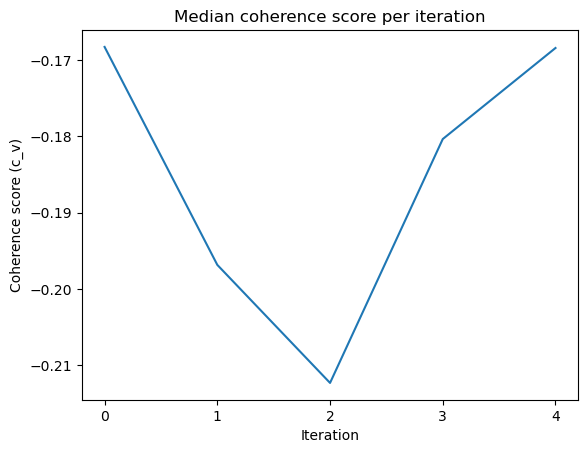

In [18]:
plt.xlabel('Iteration')
plt.ylabel('Coherence score (c_v)')
plt.title('Median coherence score per iteration')
plt.plot(results["f_val"])
plt.xticks(range(len(results["f_val"])))
plt.show()

In [19]:
max_index = results["f_val"].index(max(results["f_val"]))
print(results["f_val"][max_index])


-0.16829356558456743


In [20]:
print(results["x_iters"].keys())

num_topics = results["x_iters"]["num_topics"][max_index]
dropout = results["x_iters"]["dropout"][max_index]
lr = results["x_iters"]["lr"][max_index]

print("Optimal number of topics: ", num_topics)
print("Optimal dropout: ", dropout)
print("Optimal learning rate: ", lr)

dict_keys(['dropout', 'lr', 'num_topics'])
Optimal number of topics:  16
Optimal dropout:  0.41840902737637237
Optimal learning rate:  0.006313971035362703
